# Trial 2 Undergraduate Thesis
Goal :
- Create XGBoost and Linear Regresion Model
- Get insights from the datas
- Get the best blanket configuration

Name : Husni Naufal Zuhdi (413821)

## Regression with XGBoost

In [1]:
# Basic Numerical Packages
import numpy as np
import pandas as pd
import csv as csv
import os

# Ploting Packages
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from pylab import *

# XGBoost and Machine Learning related Packages
import xgboost as xgb
from xgboost import plot_importance
import sklearn
from sklearn import metrics
from sklearn.model_selection import cross_validate, cross_val_score, KFold, train_test_split, GridSearchCV
from scipy.stats import skew
from collections import OrderedDict

# Download files from Cloud Storage

In [2]:
# Set Cloud Storage Service Account
from google.cloud import storage
client = storage.Client.from_service_account_json(
    'key.json', project='iter-tritium-breeding-xgboost'
)

In [3]:
# Set variables of result file
enrich_lis = [0.1, 0.3, 0.5, 0.7, 0.9]
mod_ratios = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]
neutron_multis = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]
bucket = client.bucket("iter-tritium-breeding-xgboost-bucket") # Your bucket name
result_uri = "v3/results/" # Result.json files uri

# Download all result.json file in Cloud Storage Bucket
for enrich_li in enrich_lis:
    for mod_ratio in mod_ratios:
        for neutron_multi in neutron_multis:
            try:
                print("Downloading : " + str(enrich_li) + "-" + str(mod_ratio) + "-" + str(neutron_multi) + "-20-5000.json")
                blob = bucket.blob(result_uri + str(enrich_li) + "-" + str(mod_ratio) + "-" + str(neutron_multi) + "-20-5000.json")
                blob.download_to_filename("result/" + str(enrich_li) + "-" + str(mod_ratio) + "-" + str(neutron_multi) + "-20-5000.json")
            except Exception:
                pass

# Build Dataframe from Downloaded Files

In [39]:
# Read folder contain simulation results
path = "/home/ubuntu/iter-tritium-breeding-xgboost/jupyter-notebooks/2-data-analysis/result"
results = os.listdir(path=path)
results.sort()

In [40]:
# Read data in each folder
data = []
for result in results:
    # Find enrichment feature
    folder_path = path + str(result)
    folder_list = result.split('-')
    folder_list = folder_list[0:3]
    
    # Read tbr and std dev data
    try:
        json_result = pd.read_json(path + "/" + result)
        json_result = json_result["blanket_fluid_mat_(n,Xt)"]["events per source particle"]
        data.append([folder_list[0], folder_list[1], folder_list[2], json_result['result'], json_result['std. dev.']])
    except Exception:
        pass

# Build dataframe from simulation data
df = pd.DataFrame(data, columns=['Li6_enrichment', 'Moderator_ratio','Neutron_multiplier', 'Tbr_OpenMC', 'Stddev'])

# Convert all dataframe type from string into float
df.Li6_enrichment = df.Li6_enrichment.astype(float)
df.Moderator_ratio = df.Moderator_ratio.astype(float)
df.Neutron_multiplier = df.Neutron_multiplier.astype(float)

In [41]:
# Export dataframe to csv
df.to_csv("iter_tritium_breeding.csv", index=False)

# Exploratory Data Analysis

In [2]:
# Read dataset
df = pd.read_csv('iter_tritium_breeding.csv')
df.describe()

,Li6_enrichment,Moderator_ratio,Neutron_multiplier,Tbr_OpenMC,Stddev
count,180.000000,180.000000,180.000000,180.000000,180.000000
mean,0.500000,0.416667,0.416667,0.893745,0.003485
std,0.283632,0.319304,0.319304,0.070348,0.000584
min,0.100000,0.000000,0.000000,0.673701,0.001948
25%,0.300000,0.100000,0.100000,0.856910,0.003090
50%,0.500000,0.400000,0.400000,0.903328,0.003447
75%,0.700000,0.700000,0.700000,0.944982,0.003853
max,0.900000,0.900000,0.900000,1.012842,0.005278


## Trial using Hyper Opt

In [3]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [4]:
# Split dataset into train and test datasets
features_columns = [col for col in df.columns if col not in ['Tbr_OpenMC', 'Stddev']]
X_train, X_test, y_train, y_test = train_test_split(df[features_columns],df['Tbr_OpenMC'],test_size=.3, random_state=42)

In [5]:
# Load data into DMatrices
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [6]:
# Build hyperparameters space
space={'max_depth': hp.quniform("max_depth", 0, 20, 1),
       'min_child_weight' : hp.quniform('min_child_weight', 0, 20, 1),
       'gamma': hp.uniform ('gamma', 1,9),
       'reg_alpha' : hp.quniform('reg_alpha', 0,20,1),
       'reg_lambda' : hp.uniform('reg_lambda', 0,1),
       'subsample' : hp.uniform('subsample', 0.5,1),
       'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
       'learning_rate' : hp.uniform('learning_rate', 1e-5, 0.9),
       'n_estimators': 1000,
       'seed': 42
    }

In [25]:
# Build objective function
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def objective(space):
    reg=xgb.XGBRegressor(n_estimators =space['n_estimators'],
                         seed =space['seed'],
                         max_depth=int(space['max_depth']),
                         min_child_weight=int(space['min_child_weight']),
                         gamma = space['gamma'],
                         reg_alpha = int(space['reg_alpha']),
                         reg_lambda = space['reg_lambda'],
                         subsample = space['subsample'],
                         colsample_bytree = space['colsample_bytree'],
                         learning_rate = space['learning_rate'])
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    reg.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="mae",
            early_stopping_rounds=10,verbose=False)
    

    pred = reg.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    print ("MAE:", mae)
    return {'loss': mae, 'status': STATUS_OK }

In [26]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

MAE:                                                   
0.06121403941926914                                    
MAE:                                                   
0.15060148282587044                                                               
MAE:                                                                              
0.14503810669940448                                                               
MAE:                                                                              
0.09827216542575225                                                               
MAE:                                                                              
0.061834477894955595                                                              
MAE:                                                                              
0.11703333935741303                                                               
MAE:                                                                              
0.

In [27]:
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
best_hyperparams['min_child_weight'] = int(best_hyperparams['min_child_weight'])
best_hyperparams['reg_alpha'] = int(best_hyperparams['reg_alpha'])
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.9210778115815038, 'gamma': 7.260108324158889, 'learning_rate': 0.208459131270148, 'max_depth': 8, 'min_child_weight': 17, 'reg_alpha': 0, 'reg_lambda': 0.18762942477482614, 'subsample': 0.8011204842657891}


In [33]:
model = xgb.XGBRegressor(objective='reg:squarederror',**best_hyperparams)

evaluation = [( X_train, y_train), ( X_test, y_test)]

model.fit(X_train,
        y_train,
        eval_set=evaluation,
        eval_metric="mae",
        early_stopping_rounds=10,
        verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9210778115815038,
             gamma=7.260108324158889, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.208459131270148,
             max_delta_step=0, max_depth=8, min_child_weight=17, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, random_state=0, reg_alpha=0,
             reg_lambda=0.18762942477482614, scale_pos_weight=1,
             subsample=0.8011204842657891, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [34]:
# Build a validation dataframe
data_val = []
enrich = [round(0.02*x,2) for x in range(1,51)]
nm = [round(0.02*x,2) for x in range(1,51)]
mod = [round(0.02*x,2) for x in range(1,51)]
for i in enrich:
    for j in mod:
        for k in nm:
            data_val.append([i, j, k, 0, 0])
            
df_val = pd.DataFrame(data_val,
                      columns=['Li6_enrichment',
                               'Moderator_ratio',
                               'Neutron_multiplier',
                               'Tbr_XGBoost',
                               'Tbr_OpenMC'
                              ]
                     )

In [35]:
# Make predictions with best model for validation data
features_columns = ['Li6_enrichment', 'Moderator_ratio', 'Neutron_multiplier']
# dval = xgb.DMatrix(df_val[features_columns])
y_pred = model.predict(df_val[features_columns])
df_val['Tbr_XGBoost'] = y_pred

In [36]:
df_val.sort_values(by=['Tbr_XGBoost'], ascending=False).head(20)

,Li6_enrichment,Moderator_ratio,Neutron_multiplier,Tbr_XGBoost,Tbr_OpenMC
0,0.02,0.02,0.02,0.894048,0
83343,0.68,0.34,0.88,0.894048,0
83341,0.68,0.34,0.84,0.894048,0
83340,0.68,0.34,0.82,0.894048,0
83339,0.68,0.34,0.80,0.894048,0
83338,0.68,0.34,0.78,0.894048,0
83337,0.68,0.34,0.76,0.894048,0
83336,0.68,0.34,0.74,0.894048,0
83335,0.68,0.34,0.72,0.894048,0
83334,0.68,0.34,0.70,0.894048,0


[Text(0.5, 0, 'Neutron Multiplier (%)')]

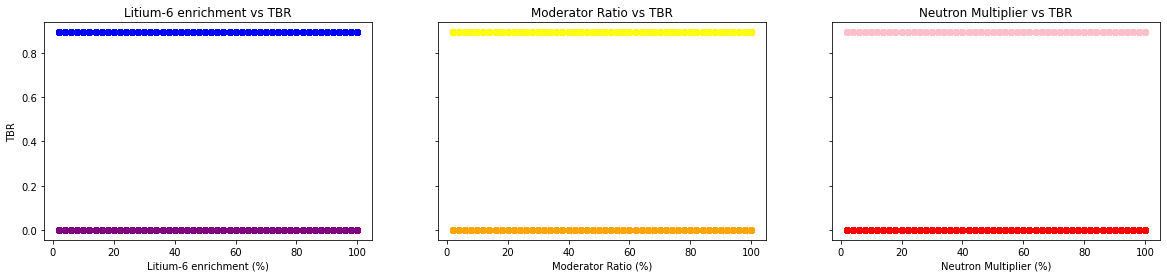

In [37]:
# Plot each features vs TBR
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(20, 4))
ax1.scatter(df_val.Li6_enrichment*100, df_val.Tbr_XGBoost, c = "blue", marker = "o")
ax1.scatter(df_val.Li6_enrichment*100, df_val.Tbr_OpenMC, c = "purple", marker = "o")
ax1.set_title("Litium-6 enrichment vs TBR")
ax1.set(xlabel='Litium-6 enrichment (%)', ylabel='TBR')
ax2.scatter(df_val.Moderator_ratio*100, df_val.Tbr_XGBoost, c = "yellow", marker = "o")
ax2.scatter(df_val.Moderator_ratio*100, df_val.Tbr_OpenMC, c = "orange", marker = "o")
ax2.set_title("Moderator Ratio vs TBR")
ax2.set(xlabel='Moderator Ratio (%)')
ax3.scatter(df_val.Neutron_multiplier*100, df_val.Tbr_XGBoost, c = "pink", marker = "o")
ax3.scatter(df_val.Neutron_multiplier*100, df_val.Tbr_OpenMC, c = "red", marker = "o")
ax3.set_title("Neutron Multiplier vs TBR")
ax3.set(xlabel='Neutron Multiplier (%)')

## Hyperparameter tunning with XGBoost CV

In [44]:
# Build an dataframe for blanket design without moderator and neutron multiplier
df_first = df.loc[(df["Moderator_ratio"] == 0.0) & (df["Neutron_multiplier"] == 0.0)]

# Export an excel file for blanket design without moderator and neutron multiplier
# datatoexcel = pd.ExcelWriter('df_first.xlsx')
# df_first.to_excel(datatoexcel)
# datatoexcel.save()

[Text(0.5, 0, 'Pengayaan Litium-6 (%)'), Text(0, 0.5, 'TBR')]

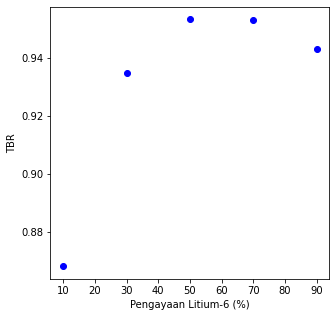

In [45]:
# Plot each 6Li vs TBR for df_first
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(df_first.Li6_enrichment*100, df_first.Tbr_OpenMC, c = "blue", marker = "o")
ax.set(xlabel='Pengayaan Litium-6 (%)', ylabel='TBR')

# Export df_first.png
# plt.savefig('df_first.png')

In [46]:
# Build an dataframe for blanket design with moderator without neutron multiplier
df_second = df.loc[(df["Neutron_multiplier"] == 0.0) & (df["Moderator_ratio"] != 0.0)]

# Export an excel file for blanket design with moderator without neutron multiplier
# datatoexcel = pd.ExcelWriter('df_second.xlsx')
# df_second.to_excel(datatoexcel)
# datatoexcel.save()

In [48]:
# Build an dataframe for blanket design with moderator and neutron multiplier
df_third = df.loc[(df["Neutron_multiplier"] != 0.0) & (df["Moderator_ratio"] != 0.0)]

# Export an excel file for blanket design with moderator and neutron multiplier
# datatoexcel = pd.ExcelWriter('df_third.xlsx')
# df_third.to_excel(datatoexcel)
# datatoexcel.save()

In [49]:
# Build diferent dataframes for each neutron multiplier
df_third_1 = df.loc[(df["Neutron_multiplier"] == 0.1) & (df["Moderator_ratio"] != 0.0)]
df_third_3 = df.loc[(df["Neutron_multiplier"] == 0.3) & (df["Moderator_ratio"] != 0.0)]
df_third_5 = df.loc[(df["Neutron_multiplier"] == 0.5) & (df["Moderator_ratio"] != 0.0)]
df_third_7 = df.loc[(df["Neutron_multiplier"] == 0.7) & (df["Moderator_ratio"] != 0.0)]
df_third_9 = df.loc[(df["Neutron_multiplier"] == 0.9) & (df["Moderator_ratio"] != 0.0)]

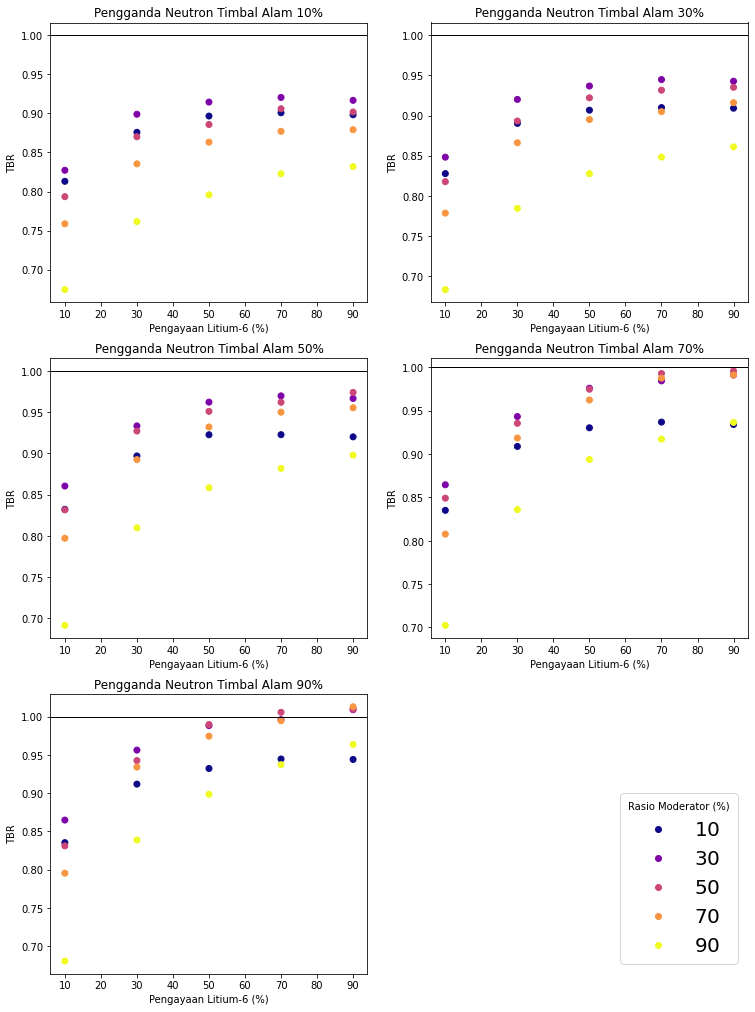

In [50]:
# Plot each 6Li vs TBR for df_third
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12.5, 17.5))

# AX1
scatter = ax1.scatter(df_third_1.Li6_enrichment*100, df_third_1.Tbr_OpenMC, c = df_third_1.Moderator_ratio*100, marker = "o", cmap=cm.plasma)
ax1.set_title("Pengganda Neutron Timbal Alam 10%")
ax1.set(xlabel='Pengayaan Litium-6 (%)', ylabel='TBR')
ax1.axhline(y=1, linewidth=1, color='k')

# AX2
scatter = ax2.scatter(df_third_3.Li6_enrichment*100, df_third_3.Tbr_OpenMC, c = df_third_3.Moderator_ratio*100, marker = "o", cmap=cm.plasma)
ax2.set_title("Pengganda Neutron Timbal Alam 30%")
ax2.set(xlabel='Pengayaan Litium-6 (%)', ylabel='TBR')
ax2.axhline(y=1, linewidth=1, color='k')

# AX3
scatter = ax3.scatter(df_third_5.Li6_enrichment*100, df_third_5.Tbr_OpenMC, c = df_third_5.Moderator_ratio*100, marker = "o", cmap=cm.plasma)
ax3.set_title("Pengganda Neutron Timbal Alam 50%")
ax3.set(xlabel='Pengayaan Litium-6 (%)', ylabel='TBR')
ax3.axhline(y=1, linewidth=1, color='k')

# AX4
scatter = ax4.scatter(df_third_7.Li6_enrichment*100, df_third_7.Tbr_OpenMC, c = df_third_7.Moderator_ratio*100, marker = "o", cmap=cm.plasma)
ax4.set_title("Pengganda Neutron Timbal Alam 70%")
ax4.set(xlabel='Pengayaan Litium-6 (%)', ylabel='TBR')
ax4.axhline(y=1, linewidth=1, color='k')

# AX5
scatter = ax5.scatter(df_third_9.Li6_enrichment*100, df_third_9.Tbr_OpenMC, c = df_third_9.Moderator_ratio*100, marker = "o", cmap=cm.plasma)
ax5.set_title("Pengganda Neutron Timbal Alam 90%")
ax5.set(xlabel='Pengayaan Litium-6 (%)', ylabel='TBR')
ax5.axhline(y=1, linewidth=1, color='k')

# AX6
ax6.axis('off')
legend = plt.legend(*scatter.legend_elements(), loc="lower right", title="Rasio Moderator (%)", prop={'size': 20})

# Export df_third.png
# plt.savefig('df_third.png')

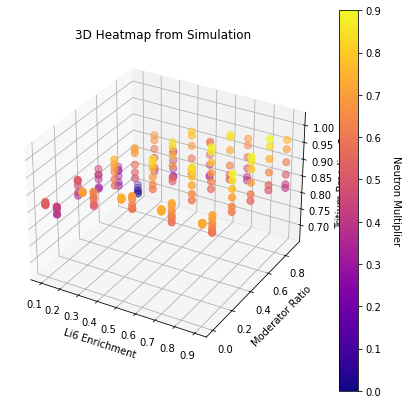

In [51]:
# Produce Heatmap Scattering
# Read the dataset
x = df["Li6_enrichment"].tolist()
y = df["Moderator_ratio"].tolist()
z = df["Tbr_OpenMC"].tolist()

colo = df["Neutron_multiplier"].tolist()

# Creating 3d figures
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Configuring colorbar
color_map = cm.ScalarMappable(cmap=cm.plasma)
color_map.set_array(colo)

# Creating the heatmap
img = ax.scatter(x, y, z, marker='o', s=50, c=z, cmap=cm.plasma)
heatmap = plt.colorbar(color_map)
heatmap.set_label('Neutron Multiplier', rotation=270, labelpad=20)

# Adding title and labels
ax.set_title("3D Heatmap from Simulation")
ax.set_xlabel('Li6 Enrichment')
ax.set_ylabel('Moderator Ratio')
ax.set_zlabel('Tritium Breeding Ratio')

# Displaying plot
plt.show()

In [56]:
# See the best blanket design
df.sort_values(by=['Tbr_OpenMC'], ascending=False).head(10)

,Li6_enrichment,Moderator_ratio,Neutron_multiplier,Tbr_OpenMC,Stddev
173,0.9,0.7,0.9,1.012842,0.004387
167,0.9,0.5,0.9,1.009560,0.003302
161,0.9,0.3,0.9,1.008993,0.003505
131,0.7,0.5,0.9,1.005552,0.004294
125,0.7,0.3,0.9,0.995924,0.003419
166,0.9,0.5,0.7,0.995918,0.003552
137,0.7,0.7,0.9,0.994566,0.003919
130,0.7,0.5,0.7,0.993001,0.005239
160,0.9,0.3,0.7,0.991248,0.003629
172,0.9,0.7,0.7,0.991240,0.004500


# Preprocessing

In [38]:
# Split dataset into train and test datasets
features_columns = [col for col in df.columns if col not in ['Tbr_OpenMC', 'Stddev']]
X_train, X_test, y_train, y_test = train_test_split(df[features_columns],df['Tbr_OpenMC'],test_size=.4, random_state=42)

In [39]:
# Load data into DMatrices
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [195]:
# Split dataset into train and test datasets
features_columns = [col for col in df.columns if col not in ['Tbr_OpenMC', 'Stddev']]
X_train, X_test, y_train, y_test = train_test_split(df[features_columns],df['Tbr_OpenMC'],test_size=.4, random_state=42)

# Build Machine Learning Model

## Set Initial Hyperparameters# Build hyperparameters space

In [40]:
# First hyperparameters
params = {
    # Parameters that we are going to tune.
    'max_depth':5,
    'min_child_weight': 1,
    'eta':.1,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 0,
    'reg_alpha': 0,
    'reg_lambda': 0,
    # Other parameters
    'objective':'reg:squarederror',
    'eval_metric':['rmse', 'mae'],
}

In [41]:
# First Model
model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, "Train"), (dtest, "Test")],
    early_stopping_rounds=5
)

[0]	Train-rmse:0.36322	Train-mae:0.35791	Test-rmse:0.35468	Test-mae:0.34843
[1]	Train-rmse:0.32697	Train-mae:0.32212	Test-rmse:0.31868	Test-mae:0.31282
[2]	Train-rmse:0.29434	Train-mae:0.28991	Test-rmse:0.28643	Test-mae:0.28090
[3]	Train-rmse:0.26499	Train-mae:0.26092	Test-rmse:0.25731	Test-mae:0.25205
[4]	Train-rmse:0.23856	Train-mae:0.23483	Test-rmse:0.23142	Test-mae:0.22645
[5]	Train-rmse:0.21478	Train-mae:0.21134	Test-rmse:0.20804	Test-mae:0.20329
[6]	Train-rmse:0.19339	Train-mae:0.19021	Test-rmse:0.18682	Test-mae:0.18227
[7]	Train-rmse:0.17411	Train-mae:0.17119	Test-rmse:0.16815	Test-mae:0.16380
[8]	Train-rmse:0.15676	Train-mae:0.15407	Test-rmse:0.15135	Test-mae:0.14715
[9]	Train-rmse:0.14115	Train-mae:0.13866	Test-rmse:0.13611	Test-mae:0.13204
[10]	Train-rmse:0.12711	Train-mae:0.12480	Test-rmse:0.12230	Test-mae:0.11832
[11]	Train-rmse:0.11447	Train-mae:0.11232	Test-rmse:0.11005	Test-mae:0.10612
[12]	Train-rmse:0.10309	Train-mae:0.10108	Test-rmse:0.09898	Test-mae:0.09511
[13]	Trai

In [42]:
print("Best RMSE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

Best RMSE: 0.01 with 67 rounds


In [43]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=1000,
    seed=42,
    nfold=10,
    metrics={'rmse', 'mae'},
    early_stopping_rounds=10
)
cv_results

,train-mae-mean,train-mae-std,train-rmse-mean,train-rmse-std,test-mae-mean,test-mae-std,test-rmse-mean,test-rmse-std
0,0.357914,0.002405,0.363220,0.002212,0.357898,0.021869,0.362662,0.020756
1,0.322123,0.002165,0.326962,0.001987,0.321918,0.019925,0.326341,0.019014
2,0.289911,0.001948,0.294334,0.001783,0.289658,0.018341,0.293785,0.017585
3,0.260920,0.001753,0.264971,0.001601,0.260592,0.016907,0.264478,0.016295
4,0.234828,0.001578,0.238544,0.001438,0.234174,0.015703,0.237817,0.015216
...,...,...,...,...,...,...,...,...
62,0.001279,0.000103,0.001677,0.000157,0.008795,0.001871,0.011153,0.002386
63,0.001251,0.000106,0.001644,0.000162,0.008797,0.001880,0.011156,0.002392
64,0.001232,0.000105,0.001624,0.000164,0.008796,0.001883,0.011156,0.002396
65,0.001206,0.000098,0.001589,0.000148,0.008784,0.001887,0.011152,0.002396


In [ ]:
# Build hyperparameters space
space={'max_depth': hp.quniform("max_depth", 0, 20, 1),
       'min_child_weight' : hp.quniform('min_child_weight', 0, 20, 1),
       'gamma': hp.uniform ('gamma', 1,9),
       'reg_alpha' : hp.quniform('reg_alpha', 0,20,1),
       'reg_lambda' : hp.uniform('reg_lambda', 0,1),
       'subsample' : hp.uniform('subsample', 0.5,1),
       'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
       'learning_rate' : hp.uniform('learning_rate', 1e-5, 0.9),
       'n_estimators': 1000,
       'seed': 42
    }

In [ ]:
# You can try wider intervals with a larger step between
# each value and then narrow it down. Here after several
# iteration I found that the optimal value was in the
# following ranges.
gridsearch_params = [
    (max_depth, min_child_weight, gamma)
    for max_depth in range(1,21)
    for min_child_weight in range(1,21)
    for gamma in [i/10. for i in range(0,9)]
]

# Define initial best params and RMSE
min_rmse = float("Inf")
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight, gamma in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}, gamma={}".format(
                             max_depth,
                             min_child_weight,
                             gamma))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    params['gamma'] = gamma
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=1000,
        seed=42,
        nfold=10,
        metrics={'rmse', 'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_rmse = cv_results['test-rmse-mean'].min()
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} and MAE {} for {} rounds".format(mean_rmse, mean_mae, boost_rounds))
    if (mean_rmse < min_rmse) & (mean_mae < min_mae):
        min_rmse = mean_rmse
        min_mae = mean_mae
        best_params = (max_depth, min_child_weight, gamma)
print("Best params: {}, {}, {}, RMSE: {}".format(best_params[0], best_params[1], best_params[2], min_rmse))

CV with max_depth=1, min_child_weight=1, gamma=0.0
	RMSE 0.027341999999999998 and MAE 0.0210145 for 283 rounds
CV with max_depth=1, min_child_weight=1, gamma=0.1
	RMSE 0.057887100000000004 and MAE 0.0458814 for 121 rounds
CV with max_depth=1, min_child_weight=1, gamma=0.2
	RMSE 0.0654423 and MAE 0.052808200000000007 for 114 rounds
CV with max_depth=1, min_child_weight=1, gamma=0.3
	RMSE 0.06639690000000001 and MAE 0.0539282 for 115 rounds
CV with max_depth=1, min_child_weight=1, gamma=0.4
	RMSE 0.06639690000000001 and MAE 0.0539282 for 115 rounds
CV with max_depth=1, min_child_weight=1, gamma=0.5
	RMSE 0.0663969 and MAE 0.0539283 for 113 rounds
CV with max_depth=1, min_child_weight=1, gamma=0.6
	RMSE 0.06639690000000001 and MAE 0.0539282 for 115 rounds
CV with max_depth=1, min_child_weight=1, gamma=0.7
	RMSE 0.06639690000000001 and MAE 0.0539282 for 115 rounds
CV with max_depth=1, min_child_weight=1, gamma=0.8
	RMSE 0.06639690000000001 and MAE 0.0539282 for 115 rounds
CV with max_depth

In [202]:
# Update first and second parameters
params['max_depth'] = best_params[0]
params['min_child_weight'] = best_params[1]
params['gamma'] = best_params[2]

In [203]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(6,11)]
    for colsample in [i/10. for i in range(6,11)]
]

min_rmse = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
        subsample,
        colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=1000,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=5
    )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample,gamma)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with subsample=1.0, colsample=1.0
	RMSE 0.008953 for 122 rounds
CV with subsample=1.0, colsample=0.9
	RMSE 0.013929399999999998 for 138 rounds
CV with subsample=1.0, colsample=0.8
	RMSE 0.013929399999999998 for 138 rounds
CV with subsample=1.0, colsample=0.7
	RMSE 0.013929399999999998 for 138 rounds
CV with subsample=1.0, colsample=0.6
	RMSE 0.027195599999999997 for 149 rounds
CV with subsample=0.9, colsample=1.0
	RMSE 0.007854400000000001 for 188 rounds
CV with subsample=0.9, colsample=0.9
	RMSE 0.0135798 for 174 rounds
CV with subsample=0.9, colsample=0.8
	RMSE 0.0135798 for 174 rounds
CV with subsample=0.9, colsample=0.7
	RMSE 0.0135798 for 174 rounds
CV with subsample=0.9, colsample=0.6
	RMSE 0.0272566 for 100 rounds
CV with subsample=0.8, colsample=1.0
	RMSE 0.006722400000000001 for 241 rounds
CV with subsample=0.8, colsample=0.9
	RMSE 0.013841000000000001 for 140 rounds
CV with subsample=0.8, colsample=0.8
	RMSE 0.013841000000000001 for 140 rounds
CV with subsample=0.8, colsam

In [204]:
# Update third and fourth parameters
params['subsample'] = best_params[0]
params['colsample_bytree'] = best_params[1]

In [205]:
# You can try wider intervals with a larger step between
# each value and then narrow it down. Here after several
# iteration I found that the optimal value was in the
# following ranges.
gridsearch_params = [
    (reg_alpha, reg_lambda)
    for reg_alpha in [i/10. for i in range(1,11)]
    for reg_lambda in [i/10. for i in range(1,11)]
]

# Define initial best params and RMSE
min_rmse = float("Inf")
best_params = None
for reg_alpha, reg_lambda in gridsearch_params:
    print("CV with reg_alpha={}, reg_lambda={}".format(reg_alpha, reg_lambda))
    # Update our parameters
    params['reg_alpha'] = reg_alpha
    params['reg_lambda'] = reg_lambda
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=1000,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=5
    )
    # Update best MAE
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (reg_alpha, reg_lambda)
print("Best params: {} and {} RMSE: {}".format(best_params[0], best_params[1], min_rmse))

CV with reg_alpha=0.1, reg_lambda=0.1
	RMSE 0.015672 for 231 rounds
CV with reg_alpha=0.1, reg_lambda=0.2
	RMSE 0.015632 for 203 rounds
CV with reg_alpha=0.1, reg_lambda=0.3
	RMSE 0.0154926 for 133 rounds
CV with reg_alpha=0.1, reg_lambda=0.4
	RMSE 0.0155972 for 138 rounds
CV with reg_alpha=0.1, reg_lambda=0.5
	RMSE 0.0158048 for 231 rounds
CV with reg_alpha=0.1, reg_lambda=0.6
	RMSE 0.016028399999999998 for 231 rounds
CV with reg_alpha=0.1, reg_lambda=0.7
	RMSE 0.0158698 for 229 rounds
CV with reg_alpha=0.1, reg_lambda=0.8
	RMSE 0.015906399999999998 for 177 rounds
CV with reg_alpha=0.1, reg_lambda=0.9
	RMSE 0.015764 for 203 rounds
CV with reg_alpha=0.1, reg_lambda=1.0
	RMSE 0.0157432 for 231 rounds
CV with reg_alpha=0.2, reg_lambda=0.1
	RMSE 0.019936199999999998 for 222 rounds
CV with reg_alpha=0.2, reg_lambda=0.2
	RMSE 0.0202368 for 177 rounds
CV with reg_alpha=0.2, reg_lambda=0.3
	RMSE 0.020379799999999997 for 177 rounds
CV with reg_alpha=0.2, reg_lambda=0.4
	RMSE 0.0201925999999999

In [206]:
# Update reg_alpha parameters
params['reg_alpha'] = best_params[0]
params['reg_lambda'] = best_params[1]

In [207]:
%time
# This can take some time…
min_rmse = float("Inf")
best_params = None
for eta in [0.01, 0.05, 0.07, 0.1, 0.3, 0.5]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time cv_results = xgb.cv(params,dtrain,num_boost_round=1000,seed=42,nfold=5,metrics=['rmse'],early_stopping_rounds=5)
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, RMSE: {}".format(best_params, min_rmse))

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.2 µs
CV with eta=0.01
CPU times: user 25.4 s, sys: 60.1 ms, total: 25.5 s
Wall time: 1.6 s
	RMSE 0.016215 for 999 rounds

CV with eta=0.05
CPU times: user 9.85 s, sys: 43.9 ms, total: 9.89 s
Wall time: 621 ms
	RMSE 0.015137800000000002 for 392 rounds

CV with eta=0.07
CPU times: user 6.39 s, sys: 11.8 ms, total: 6.4 s
Wall time: 404 ms
	RMSE 0.015034200000000001 for 257 rounds

CV with eta=0.1
CPU times: user 3.42 s, sys: 11.9 ms, total: 3.43 s
Wall time: 220 ms
	RMSE 0.0154926 for 133 rounds

CV with eta=0.3
CPU times: user 1.82 s, sys: 0 ns, total: 1.82 s
Wall time: 118 ms
	RMSE 0.0157806 for 70 rounds

CV with eta=0.5
CPU times: user 1.19 s, sys: 0 ns, total: 1.19 s
Wall time: 77.9 ms
	RMSE 0.01688 for 42 rounds

Best params: 0.07, RMSE: 0.015034200000000001


In [208]:
# Update fifth parameters
params['eta'] = best_params

In [209]:
new_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, "Train"), (dtest, "Test")],
    early_stopping_rounds=5
)

print("Best RMSE: {:.2f} in {} rounds".format(new_model.best_score, new_model.best_iteration+1))

[0]	Train-rmse:0.37599	Train-mae:0.37025	Test-rmse:0.36709	Test-mae:0.36041
[1]	Train-rmse:0.35031	Train-mae:0.34465	Test-rmse:0.34150	Test-mae:0.33480
[2]	Train-rmse:0.32683	Train-mae:0.32104	Test-rmse:0.31817	Test-mae:0.31127
[3]	Train-rmse:0.30456	Train-mae:0.29833	Test-rmse:0.29600	Test-mae:0.28856
[4]	Train-rmse:0.28402	Train-mae:0.27761	Test-rmse:0.27541	Test-mae:0.26769
[5]	Train-rmse:0.26485	Train-mae:0.25848	Test-rmse:0.25635	Test-mae:0.24853
[6]	Train-rmse:0.24706	Train-mae:0.24069	Test-rmse:0.23868	Test-mae:0.23073
[7]	Train-rmse:0.23029	Train-mae:0.22385	Test-rmse:0.22204	Test-mae:0.21388
[8]	Train-rmse:0.21507	Train-mae:0.20845	Test-rmse:0.20681	Test-mae:0.19833
[9]	Train-rmse:0.20111	Train-mae:0.19426	Test-rmse:0.19287	Test-mae:0.18402
[10]	Train-rmse:0.18797	Train-mae:0.18097	Test-rmse:0.17994	Test-mae:0.17083
[11]	Train-rmse:0.17562	Train-mae:0.16871	Test-rmse:0.16774	Test-mae:0.15855
[12]	Train-rmse:0.16427	Train-mae:0.15714	Test-rmse:0.15643	Test-mae:0.14686
[13]	Trai

In [210]:
# Build a validation dataframe
data_val = []
enrich = [round(0.02*x,2) for x in range(1,51)]
nm = [round(0.02*x,2) for x in range(1,51)]
mod = [round(0.02*x,2) for x in range(1,51)]
for i in enrich:
    for j in mod:
        for k in nm:
            data_val.append([i, j, k, 0, 0])
            
df_val = pd.DataFrame(data_val,
                      columns=['Li6_enrichment',
                               'Moderator_ratio',
                               'Neutron_multiplier',
                               'Tbr_XGBoost',
                               'Tbr_OpenMC'
                              ]
                     )

In [211]:
# # Move TBR_OpenMC in df dataframe into d_val dataframe
# for i in enrich:
#     for j in mod:
#         for k in nm:
#             try:
#                 tbr_row = df.loc[(df["Li6_enrichment"] == i) & (df["Moderator_ratio"] == j) & (df["Neutron_multiplier"] == k)]
#                 tbr_row = tbr_row['Tbr_OpenMC']
#                 tbr_row = tbr_row.to_numpy()

#                 tbr_ml_row = df_val.loc[(df_val["Li6_enrichment"] == i) & (df_val["Moderator_ratio"] == j) & (df_val["Neutron_multiplier"] == k)]
#                 df_val.iloc[tbr_ml_row.index, 4] = tbr_row[0]
#                 print("Move TBR_OpenMC " + str(i) + str(j) + str(k) + " in df dataframe into d_val dataframe")
#             except Exception:
#                 pass

In [212]:
# Make predictions with best model for validation data
features_columns = ['Li6_enrichment', 'Moderator_ratio', 'Neutron_multiplier']
dval = xgb.DMatrix(df_val[features_columns])
y_pred = new_model.predict(dval)
df_val['Tbr_XGBoost'] = y_pred

In [213]:
df_val.sort_values(by=['Tbr_XGBoost'], ascending=False).head(20)

,Li6_enrichment,Moderator_ratio,Neutron_multiplier,Tbr_XGBoost,Tbr_OpenMC
80645,0.66,0.26,0.92,0.991979,0
75749,0.62,0.30,1.00,0.991979,0
75843,0.62,0.34,0.88,0.991979,0
75842,0.62,0.34,0.86,0.991979,0
75841,0.62,0.34,0.84,0.991979,0
75840,0.62,0.34,0.82,0.991979,0
75839,0.62,0.34,0.80,0.991979,0
75799,0.62,0.32,1.00,0.991979,0
75798,0.62,0.32,0.98,0.991979,0
95542,0.78,0.22,0.86,0.991979,0


[Text(0.5, 0, 'Neutron Multiplier (%)')]

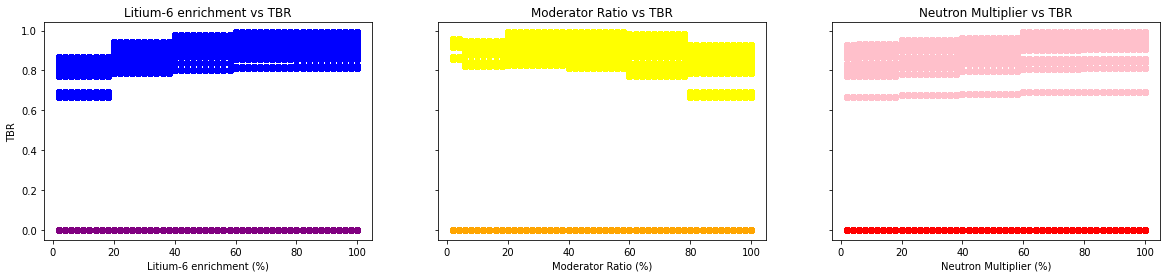

In [214]:
# Plot each features vs TBR
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(20, 4))
ax1.scatter(df_val.Li6_enrichment*100, df_val.Tbr_XGBoost, c = "blue", marker = "o")
ax1.scatter(df_val.Li6_enrichment*100, df_val.Tbr_OpenMC, c = "purple", marker = "o")
ax1.set_title("Litium-6 enrichment vs TBR")
ax1.set(xlabel='Litium-6 enrichment (%)', ylabel='TBR')
ax2.scatter(df_val.Moderator_ratio*100, df_val.Tbr_XGBoost, c = "yellow", marker = "o")
ax2.scatter(df_val.Moderator_ratio*100, df_val.Tbr_OpenMC, c = "orange", marker = "o")
ax2.set_title("Moderator Ratio vs TBR")
ax2.set(xlabel='Moderator Ratio (%)')
ax3.scatter(df_val.Neutron_multiplier*100, df_val.Tbr_XGBoost, c = "pink", marker = "o")
ax3.scatter(df_val.Neutron_multiplier*100, df_val.Tbr_OpenMC, c = "red", marker = "o")
ax3.set_title("Neutron Multiplier vs TBR")
ax3.set(xlabel='Neutron Multiplier (%)')

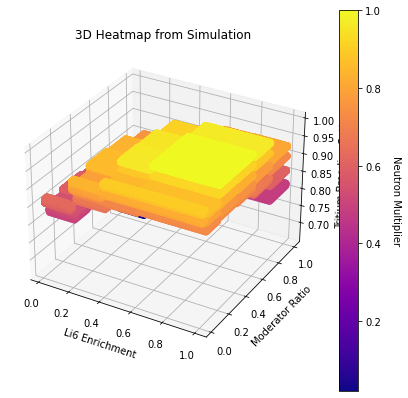

In [215]:
# Read the dataset
x = df_val["Li6_enrichment"].tolist()
y = df_val["Moderator_ratio"].tolist()
z = df_val["Tbr_XGBoost"].tolist()

colo = df_val["Neutron_multiplier"].tolist()

# Creating 3d figures
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Configuring colorbar
color_map = cm.ScalarMappable(cmap=cm.plasma)
color_map.set_array(colo)

# Creating the heatmap
img = ax.scatter(x, y, z, marker='o', s=50, c=z, cmap=cm.plasma)
heatmap = plt.colorbar(color_map)
heatmap.set_label('Neutron Multiplier', rotation=270, labelpad=20)

# Adding title and labels
ax.set_title("3D Heatmap from Simulation")
ax.set_xlabel('Li6 Enrichment')
ax.set_ylabel('Moderator Ratio')
ax.set_zlabel('Tritium Breeding Ratio')

# Displaying plot
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

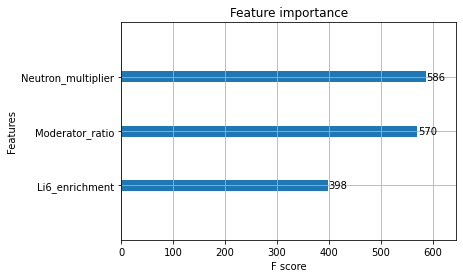

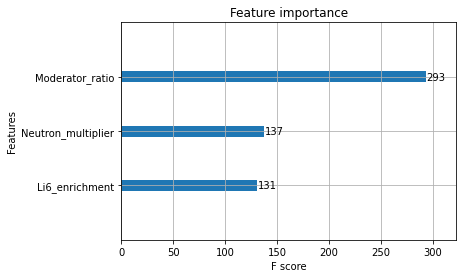

In [216]:
xgb.plot_importance(model)
xgb.plot_importance(new_model)